# Test the Pressure atmospheric transparency Emulator

- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNRS
- creation date : 2023/10/24
- last update : 2023/10/24


This emulator is based from datagrid of atmospheric transparencies extracted from libradtran

- access to data see https://setuptools.pypa.io/en/latest/userguide/datafiles.html

In [1]:
import numpy as np
import pandas as pd
import os
from scipy import interpolate
from astropy.io import fits
from astropy.table import Table
import seaborn as sns
import copy

from importlib.resources import files

In [2]:
from atmpressemulator.atmpressemulator import AtmPressEmulator
from simpleemulator.simpleatmemulator import Dict_Of_sitesAltitudes,Dict_Of_sitesPressures

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

# to enlarge the sizes
params = {'legend.fontsize': 'large',
          'figure.figsize': (16, 8),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
plt.rcParams.update(params)


In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
FLAG_CHECKWITHLIBRADTRAN = False

In [6]:
AIRMASSMIN = 1.0
AIRMASSMAX=2.6
DAM = 0.2
airmasses = np.arange(AIRMASSMIN,AIRMASSMAX,DAM)
NAM=len(airmasses)

In [7]:
PWVMIN = 0
PWVMAX = 11
DPWV = 0.5
pwvs = np.arange(PWVMIN,PWVMAX,DPWV)
NPWV = len(pwvs)

In [8]:
pwvs

array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,
        5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. , 10.5])

In [9]:
OZMIN = 0
OZMAX = 600
DOZ   = 50
ozs = np.arange(OZMIN,OZMAX,DOZ)
NOZ = len(ozs)

In [10]:
ozs

array([  0,  50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550])

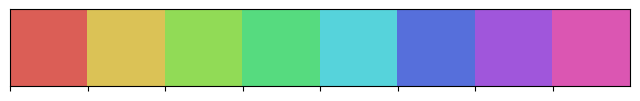

In [11]:
hls_colors = sns.color_palette("hls", NAM)
sns.palplot(hls_colors)

# Check emulator

In [12]:
#path_data =  find_data_path()  
#print("path_data = ",path_data)
#print(path_data)

In [13]:
emul =  AtmPressEmulator(pressure=800.)

Observatory LSST found in preselected observation sites


In [14]:
WL = emul.GetWL()

## Check emulator with Rayleigh scattering

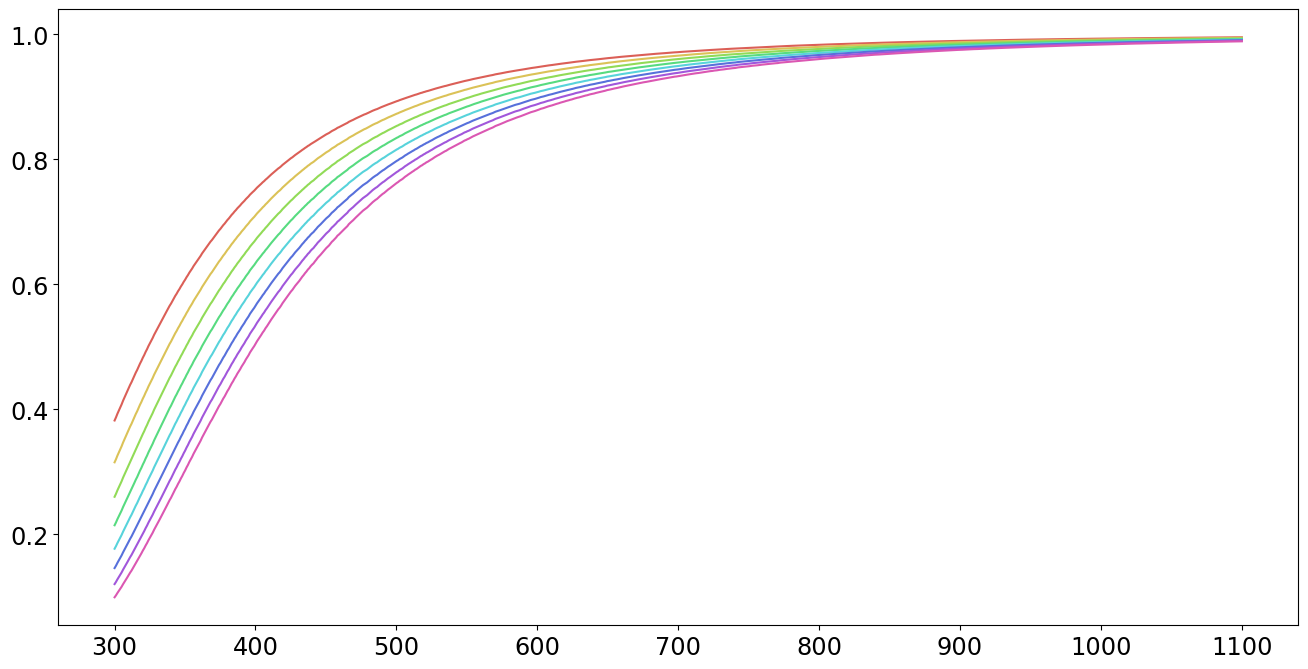

In [15]:
for idx,am in enumerate(airmasses):

    transm = emul.GetRayleighTransparencyArray(WL,am)
    plt.plot(WL,transm,color=hls_colors[idx])

## Check emulator with Oxygen O2 absorption

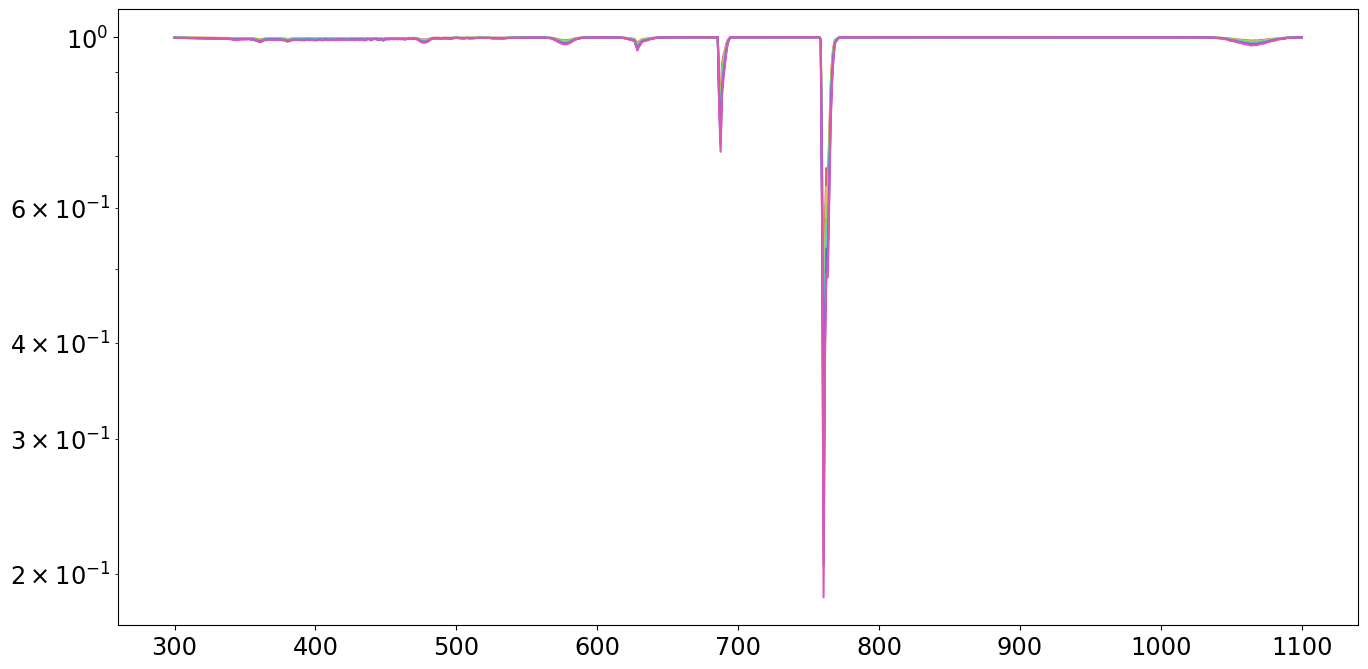

In [16]:
for idx,am in enumerate(airmasses):

    transm = emul.GetO2absTransparencyArray(WL,am)
    plt.plot(WL,transm,color=hls_colors[idx])
plt.yscale('log')

## Check emulator with PWV absorption

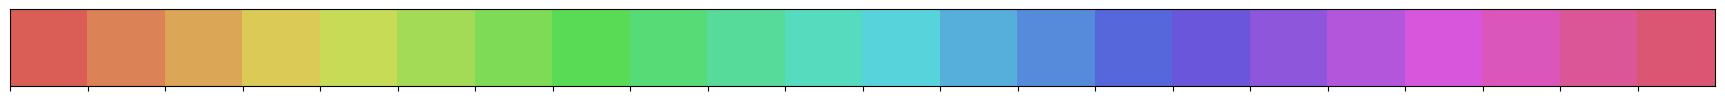

In [17]:
hls_colors = sns.color_palette("hls", NPWV)
sns.palplot(hls_colors)

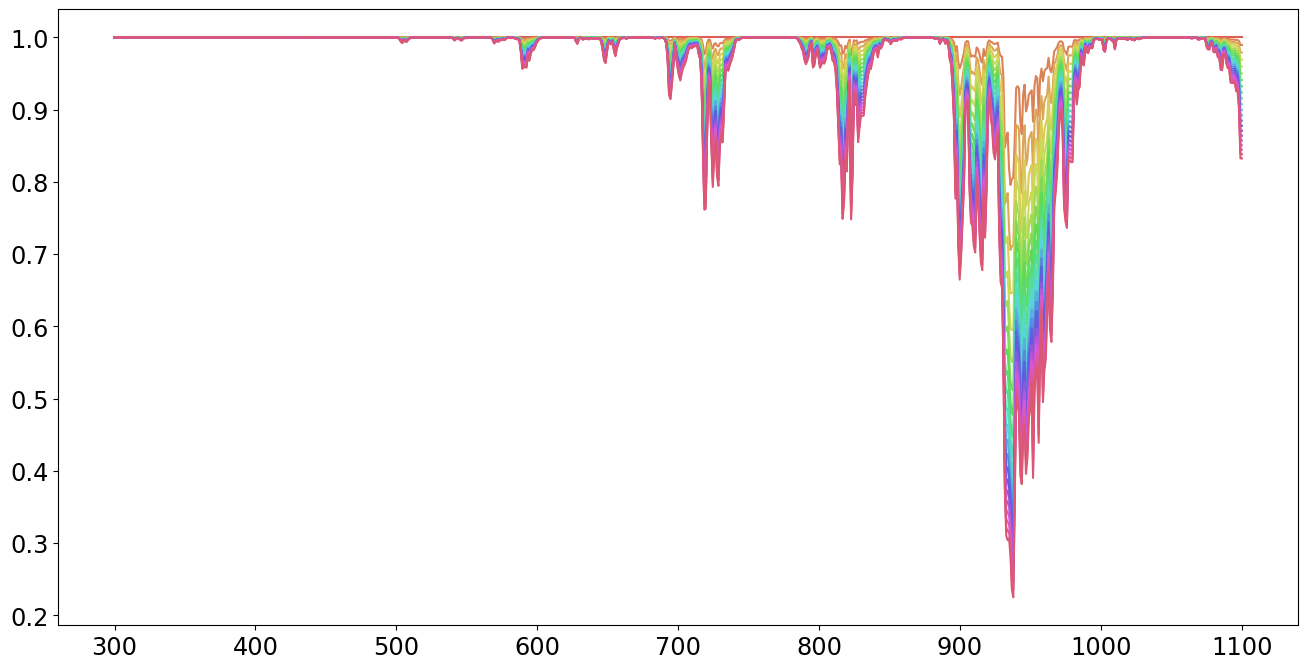

In [18]:
for idx,pwv in enumerate(pwvs):

    transm = emul.GetPWVabsTransparencyArray(WL,am,pwv)
    plt.plot(WL,transm,color=hls_colors[idx])

## Check emulator with Ozone absorption

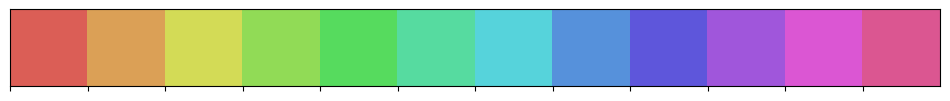

In [19]:
hls_colors = sns.color_palette("hls", NOZ)
sns.palplot(hls_colors)

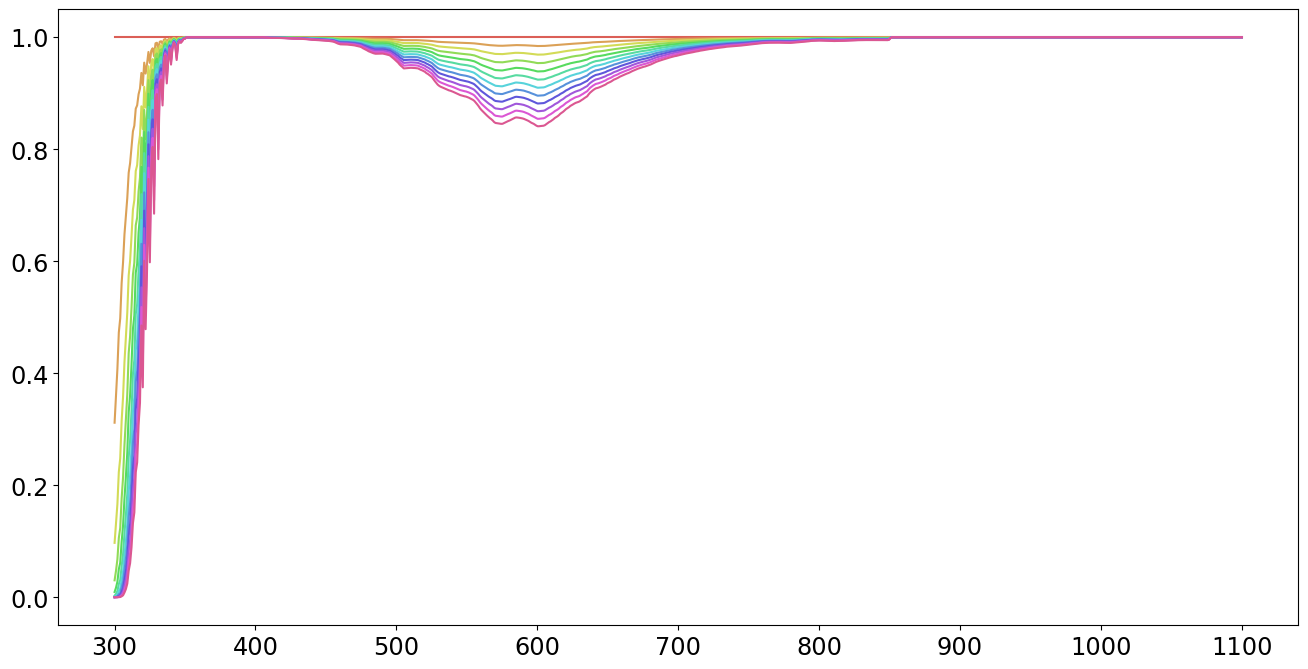

In [20]:
for idx,oz in enumerate(ozs):

    transm = emul.GetOZabsTransparencyArray(WL,am,oz)
    plt.plot(WL,transm,color=hls_colors[idx])

## Check emulator with combined ascattering and absorption process and check with libradtran

In [21]:
am0 = 1.0
pwv0 = 5.0
oz0 = 500.
transm1 = emul.GetGriddedTransparencies(WL,am0,pwv0,oz0,flagRayleigh=True)
label0=f"emulator : airmass = {am0:.2f}, pwv  = {pwv0:.2f} mm , oz = {oz0:.1f} DU"

In [22]:
am1 = 2.0
pwv1 = 5.0
oz1 = 500.
transm2 = emul.GetGriddedTransparencies(WL,am1,pwv1,oz1,flagRayleigh=True)
label1=f"emulator : airmass = {am1:.2f},  pwv  = {pwv1:.2f} mm , oz = {oz1:.1f} DU"

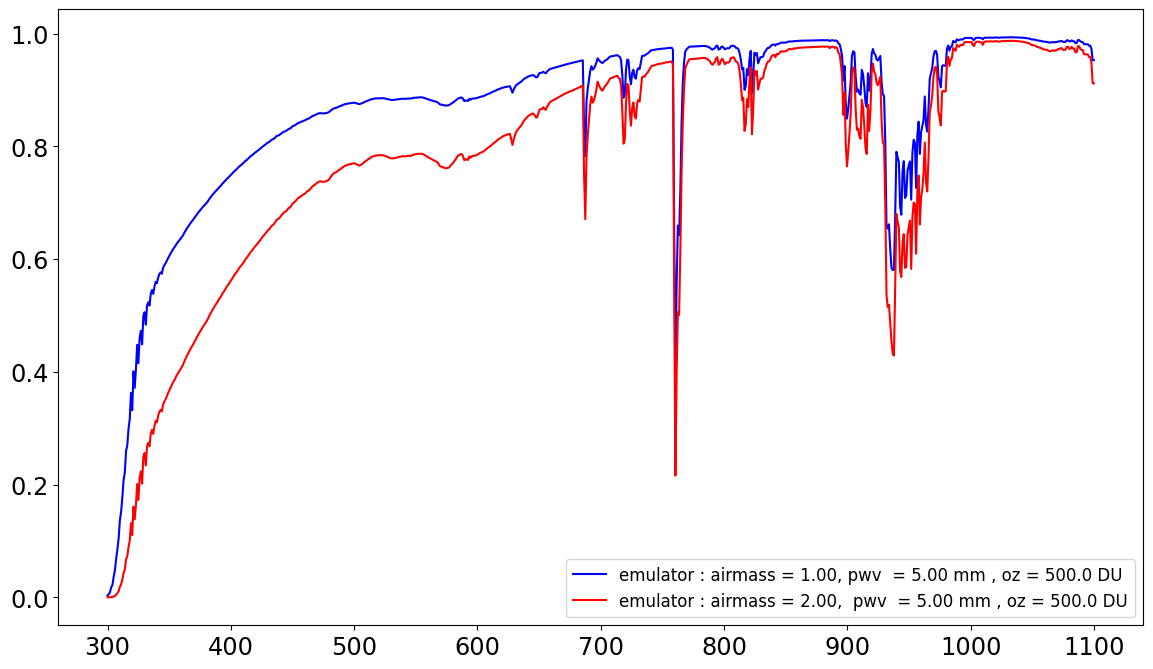

In [23]:
plt.figure(figsize=(14,8))

plt.plot(WL,transm1,'b-',label=label0)
plt.plot(WL,transm2,'r-',label=label1)
plt.legend()

In [24]:
if FLAG_CHECKWITHLIBRADTRAN:
    path,thefile = libsimulateVisible.ProcessSimulation(am0,pwv0,oz0,0,prof_str='us',proc_str='sa',cloudext=0.0, FLAG_VERBOSE=False)
    data1 = np.loadtxt(os.path.join(path,thefile))
    path,thefile = libsimulateVisible.ProcessSimulation(am1,pwv1,oz1,0,prof_str='us',proc_str='sa',cloudext=0.0, FLAG_VERBOSE=False)
    data2 = np.loadtxt(os.path.join(path,thefile))

In [25]:
if FLAG_CHECKWITHLIBRADTRAN:
    plt.figure(figsize=(14,8))
    plt.plot(WL,transm1,'b-',label=label0)
    plt.plot(data1[:,0],data1[:,1],'k:',label="librandtran")
    plt.plot(WL,transm2,'r-',label=label1)
    plt.plot(data2[:,0],data2[:,1],'k-.',label="libradtran")
    plt.legend()

## Check with aerosols

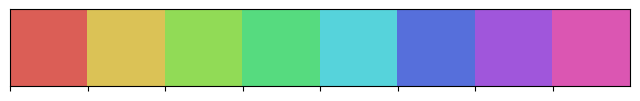

In [26]:
hls_colors = sns.color_palette("hls", NAM)
sns.palplot(hls_colors)

(0.0, 1.1)

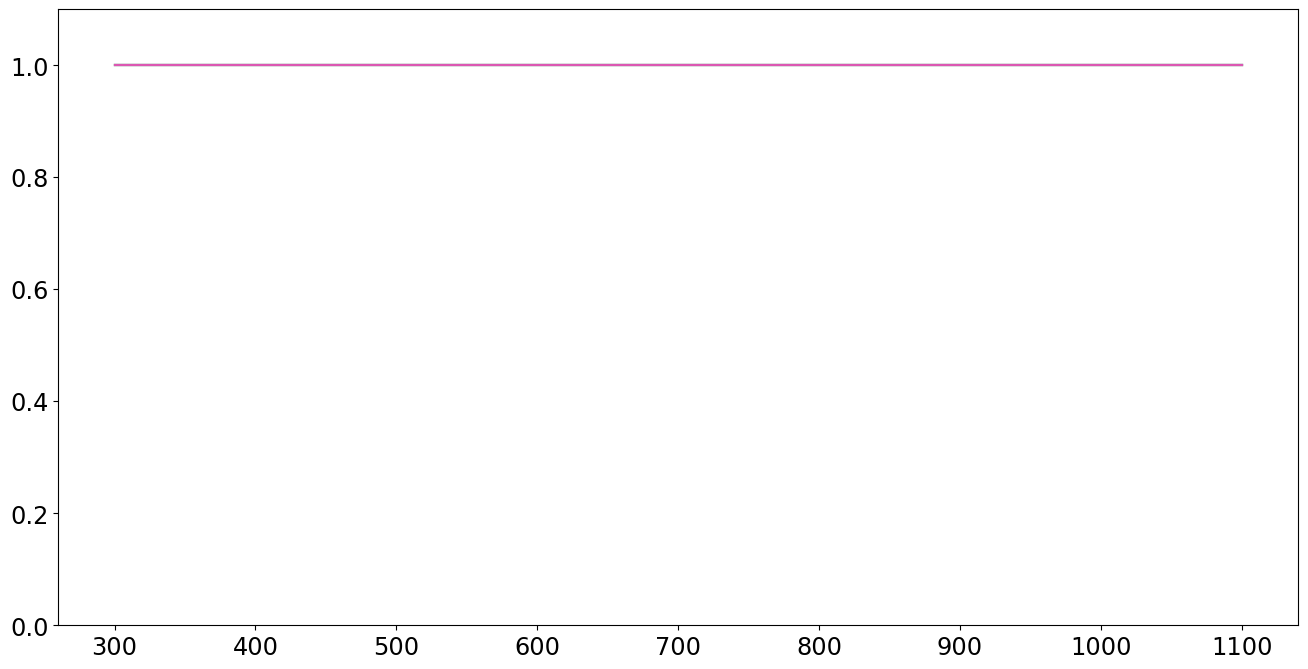

In [27]:
ncomp=0

for idx,am in enumerate(airmasses):

    transm = emul.GetAerosolsTransparencies(WL,am,ncomp)
    plt.plot(WL,transm,color=hls_colors[idx])
    
plt.ylim(0,1.1)

(0.0, 1.0)

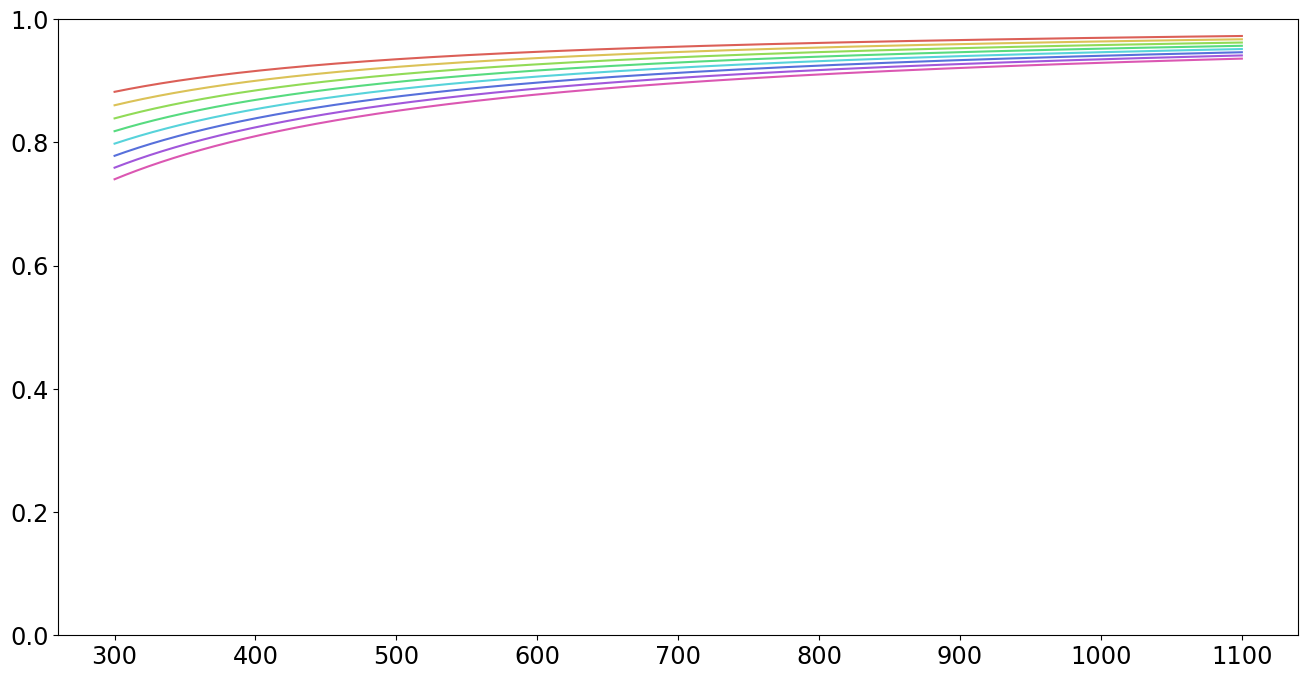

In [28]:
taus = [0.05, 0.01]
betas = [- 1.0, -2]
ncomp=2

for idx,am in enumerate(airmasses):

    transm = emul.GetAerosolsTransparencies(WL,am,ncomp,taus,betas)
    plt.plot(WL,transm,color=hls_colors[idx])
    
plt.ylim(0,1)

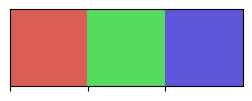

In [29]:
all_taus = [0.01, 0.05, 0.1]
betas = [- 1.0]
ncomp=1
am=1

NTAUS = len(all_taus)

hls_colors = sns.color_palette("hls", NTAUS)
sns.palplot(hls_colors)

(0.0, 1.0)

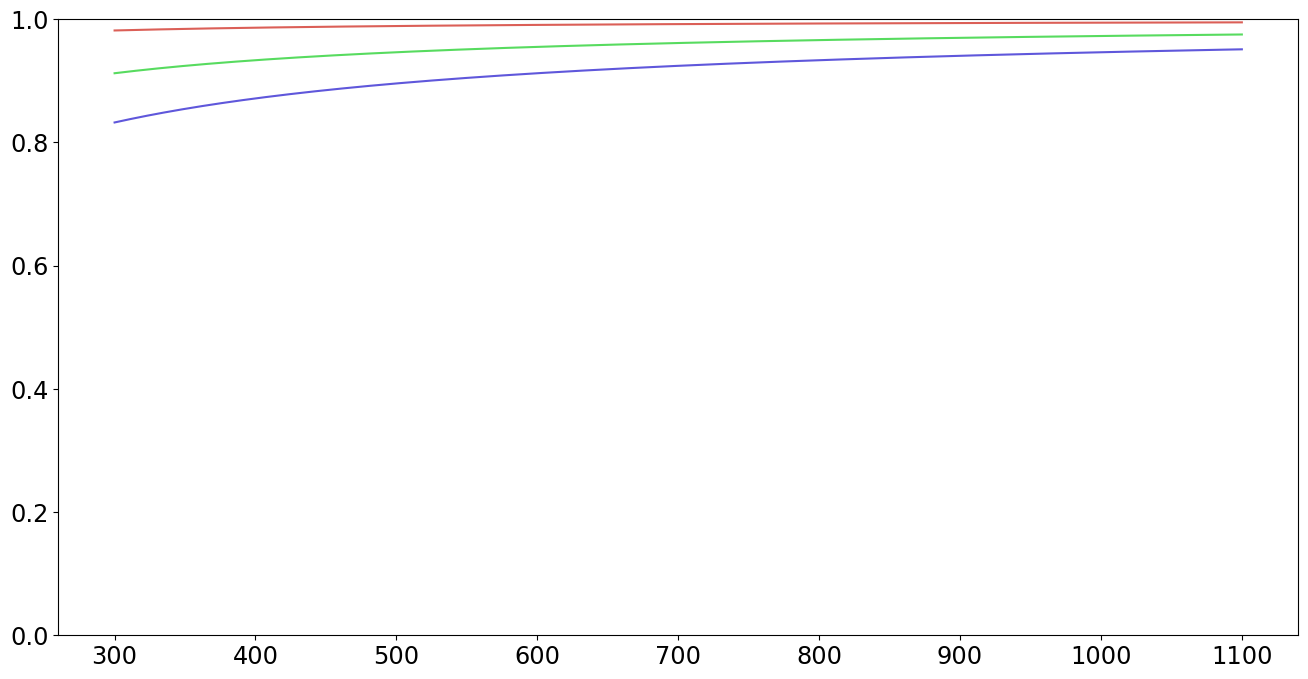

In [30]:
for idx,tau in enumerate(all_taus):
    taus = [tau]
    transm = emul.GetAerosolsTransparencies(WL,am,ncomp,taus,betas)
    plt.plot(WL,transm,color=hls_colors[idx])
    
plt.ylim(0,1)

## Test all combined transmission

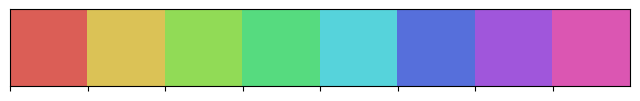

In [31]:
hls_colors = sns.color_palette("hls", NAM)
sns.palplot(hls_colors)

### Without aerosols

(0.0, 1.0)

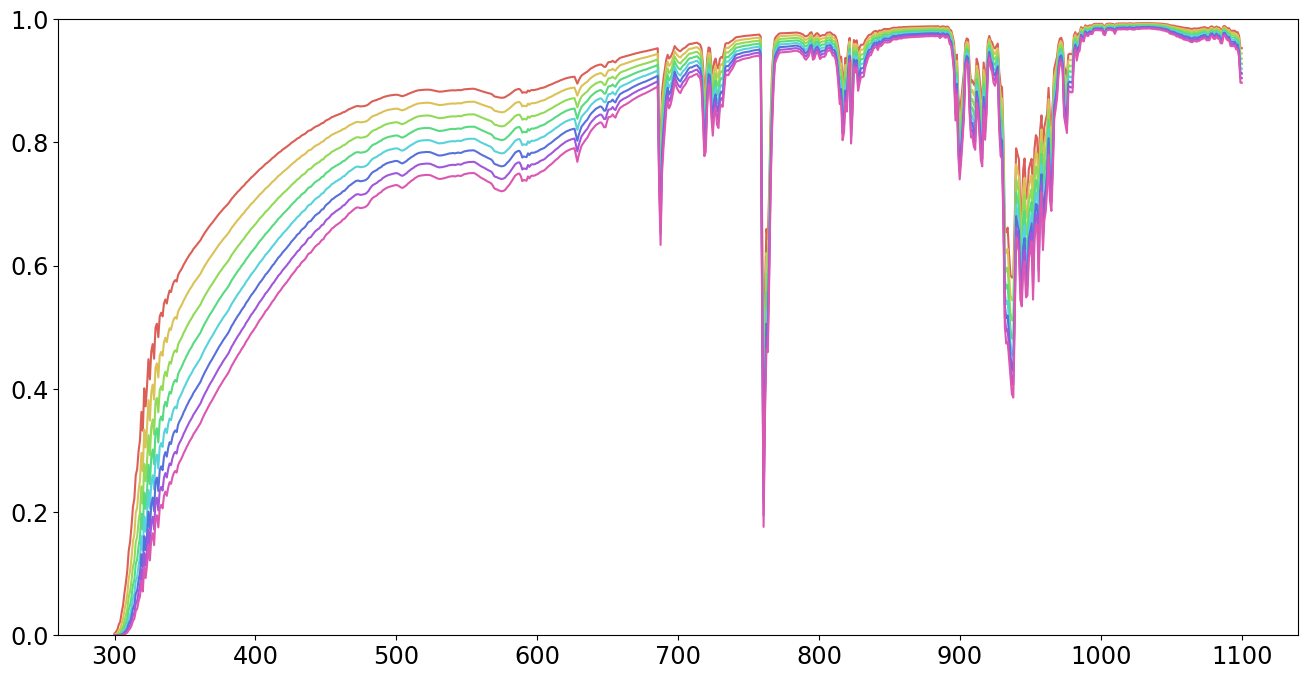

In [32]:
pwv0 = 5.0
oz0 = 500.

for idx,am in enumerate(airmasses):

    transm = emul.GetAllTransparencies(WL,am,pwv0,oz0)
    plt.plot(WL,transm,color=hls_colors[idx])
    
plt.ylim(0,1)

### With aerosols

(0.0, 1.0)

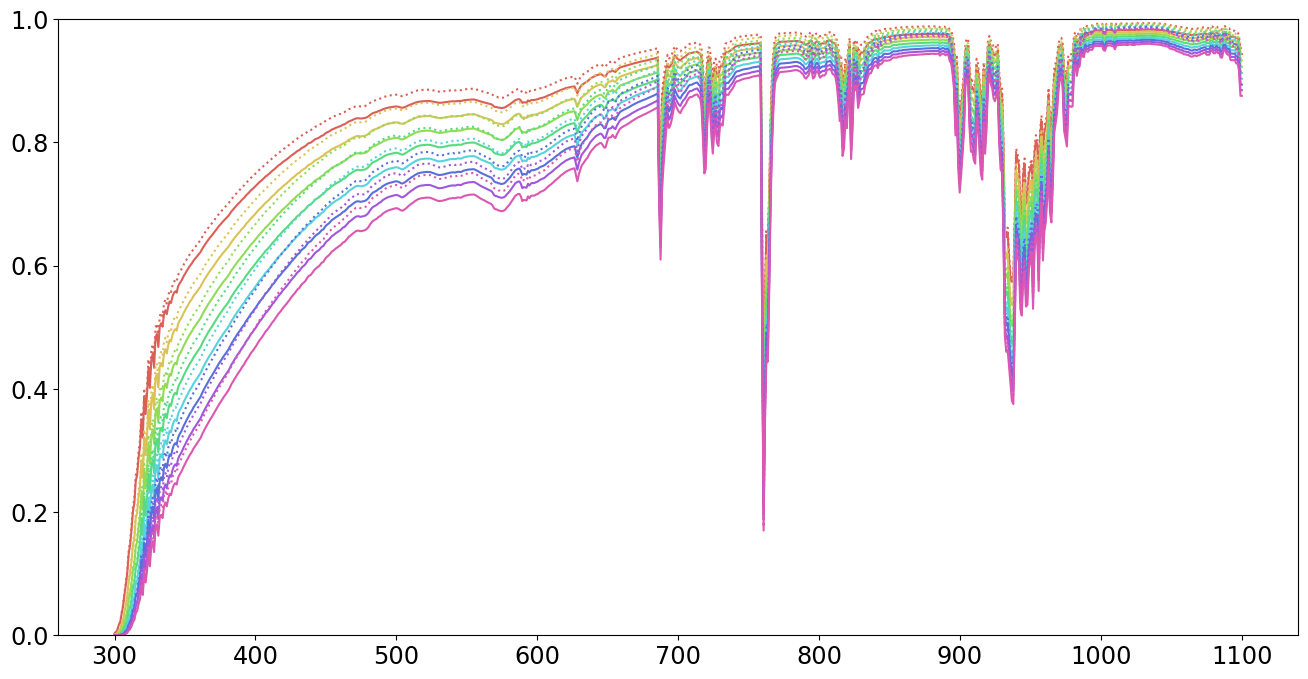

In [33]:
wv0 = 5.0
oz0 = 500.
ncomp=1
taus= [0.02]
betas = [-1]

for idx,am in enumerate(airmasses):

    transm = emul.GetAllTransparencies(WL,am,pwv0,oz0,ncomp=ncomp, taus=taus, betas=betas, flagAerosols=True)
    transmnoaer = emul.GetAllTransparencies(WL,am,pwv0,oz0)
    plt.plot(WL,transm,color=hls_colors[idx])
    plt.plot(WL,transmnoaer,":",color=hls_colors[idx])
    
plt.ylim(0,1)